# WHO: Life Expectancy Dataset
**Project Goals**:
 - Wrangle WHO dataset to increase usability for project.
 - Utilize dataset to explore correlating features to life expectancy.
 - Create machine learning model to predict life expectancy.

In [1]:
import pandas as pd
import numpy as np
import wrangle
import explore

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

## Acquire Data

In [2]:
df = wrangle.acquire_who_data()

In [3]:
df.sample(5).T

,2390,2133,678,1366,2722
Country,Somalia,Romania,Cyprus,Kenya,Uganda
Year,2002,2001,2010,2011,2007
Status,Developing,Developed,Developed,Developing,Developing
Life expectancy,58,78,79.5,61.2,55.5
Adult Mortality,348,179,59,278,41
infant deaths,47,4,0,60,88
Alcohol,0.01,9.78,11.32,1.8,9.65
percentage expenditure,0,180.11,283.33,109.705,6.00253
Hepatitis B,NaN,98,96,96,73
Measles,9559,10,18,2395,3776


In [4]:
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
975,Gambia,2002,Developing,56.6,298.0,3,2.08,0.000000,92.0,32,...,86.0,3.75,87.0,2.5,NaN,NaN,9.8,9.8,0.392,7.0
654,Croatia,2002,Developed,74.8,124.0,0,13.39,11.636151,NaN,6,...,95.0,6.19,95.0,0.1,653.716370,444.0,2.0,2.0,0.759,12.6
1205,Indonesia,2012,Developing,68.5,183.0,129,0.08,254.468826,83.0,15489,...,84.0,2.90,83.0,0.3,3687.953996,248883232.0,1.5,1.4,0.669,12.6


### Acquire Takeaways:
 - I brought in my data using my acquire function
 - My info function gives me insight into the data types and null counts in my df
 - I will need to strip whitespaces from column names, lowercase and rename as well.
 - I will definitely need to impute some nulls because dropping would be too much
 - A distplot will give me a good idea of how to impute our nulls

## Prepare Data

In [5]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [6]:
df = wrangle.prep_who(df)

In [7]:
df.head()

,country,year,developed_country,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hep_b,measles,...,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19yrs,thinness_5-9yrs,income_comp_resources,yrs_education,country_avg
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,64.5625
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,64.5625
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,64.5625
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,64.5625
4,Afghanistan,2011,0,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,64.5625


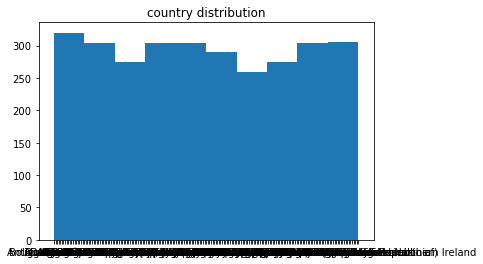

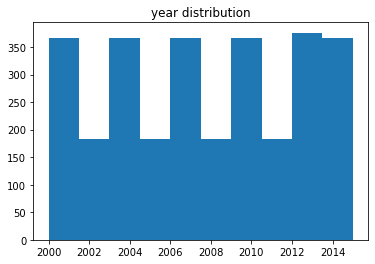

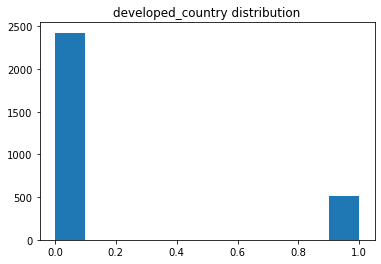

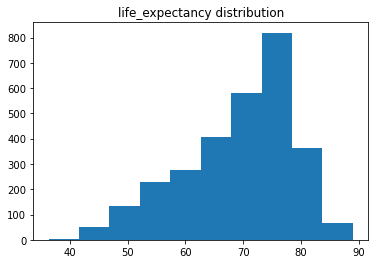

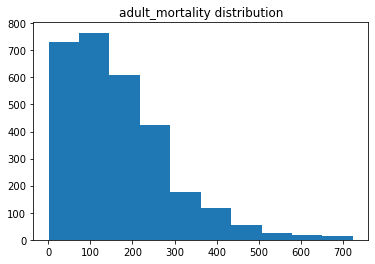

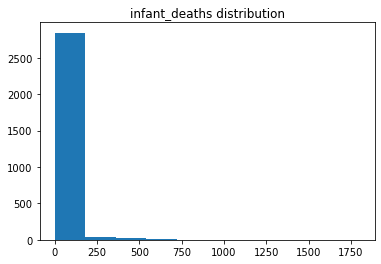

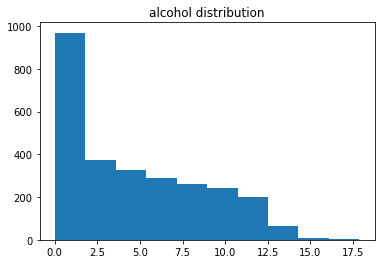

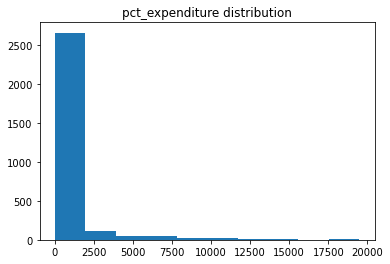

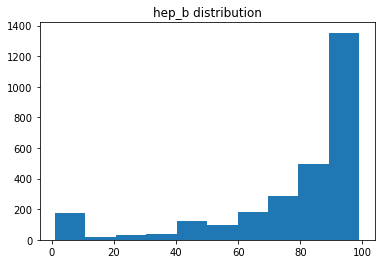

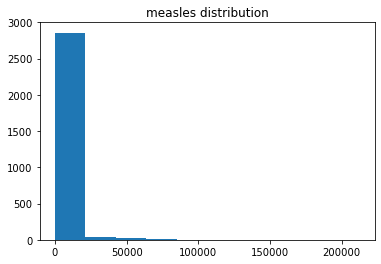

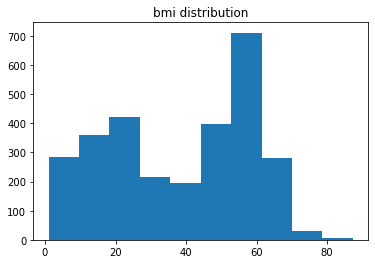

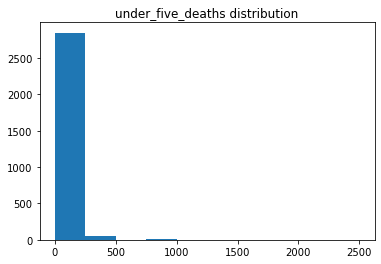

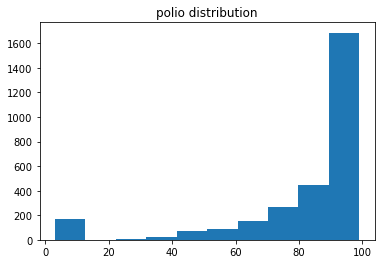

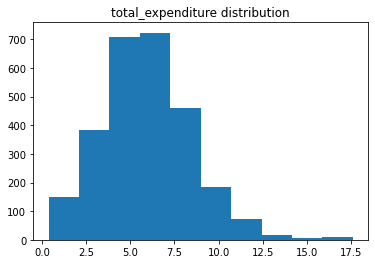

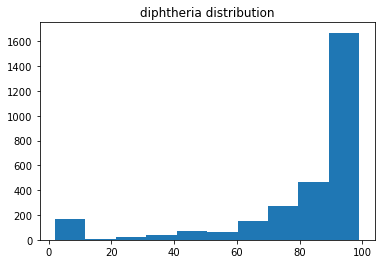

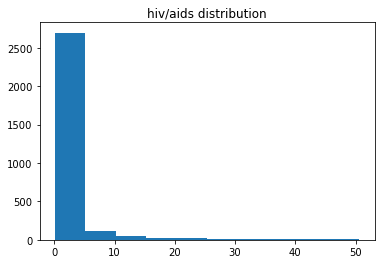

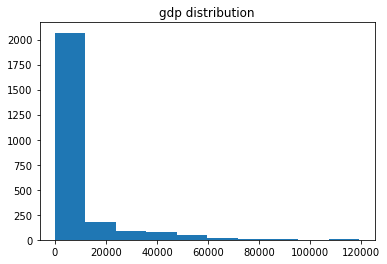

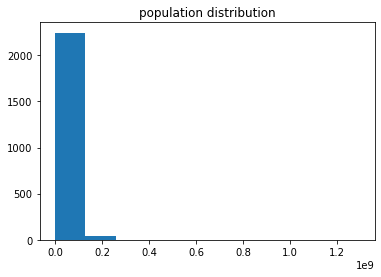

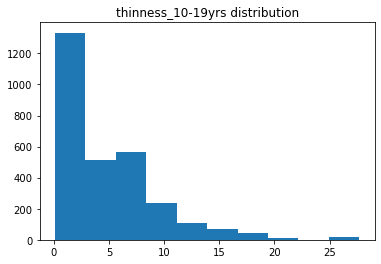

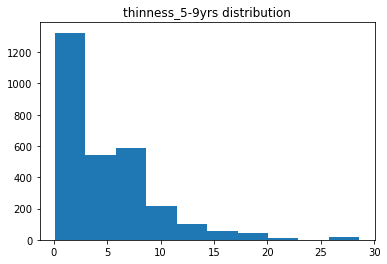

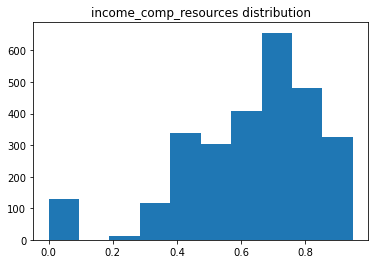

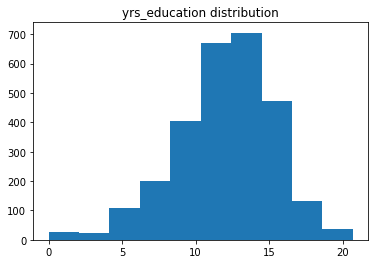

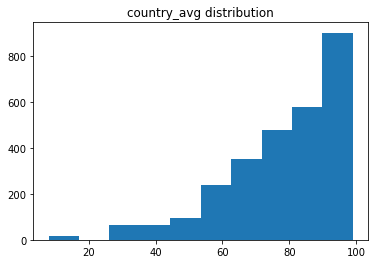

In [8]:
explore.visualize_distribution(df, df.columns);

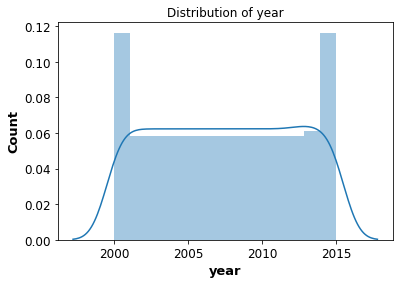

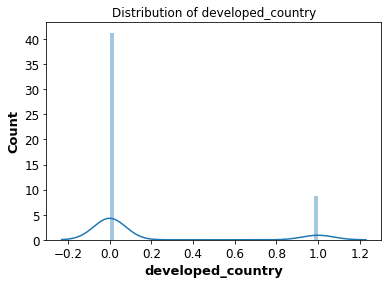

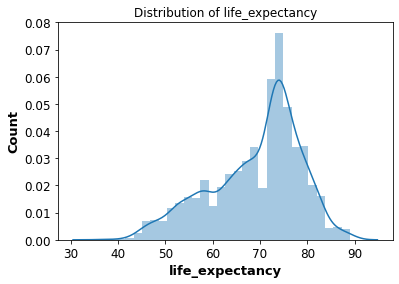

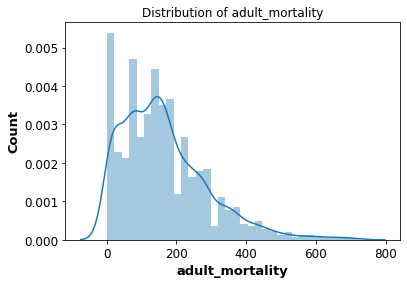

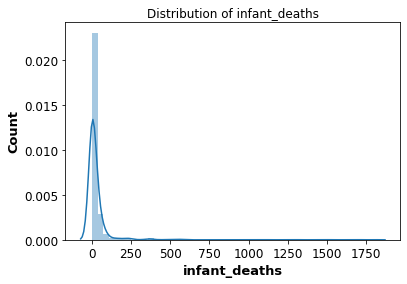

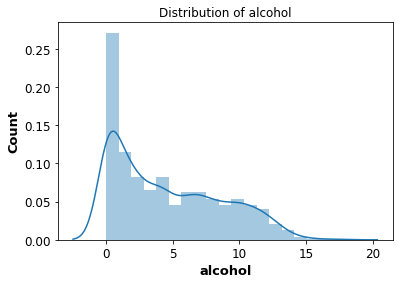

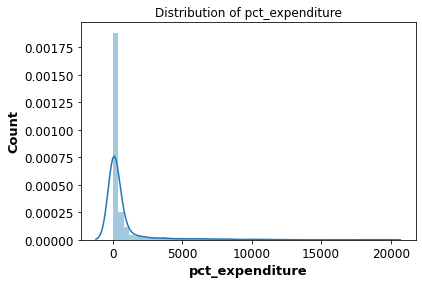

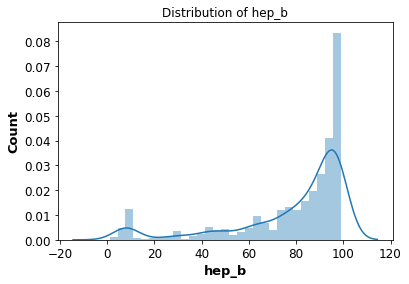

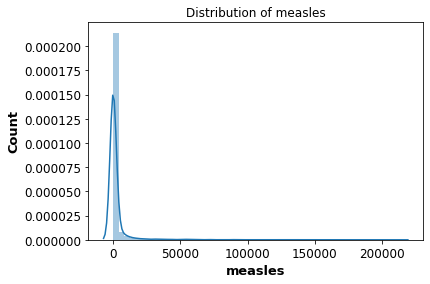

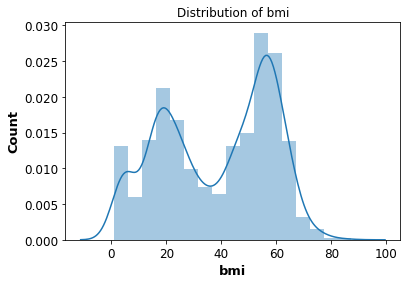

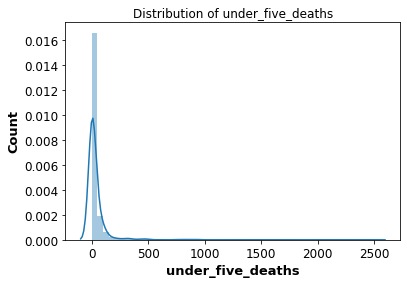

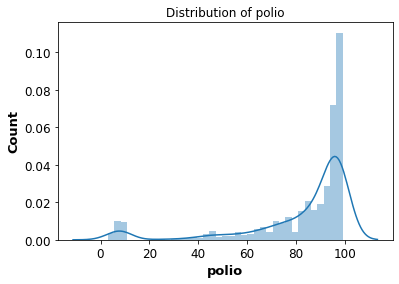

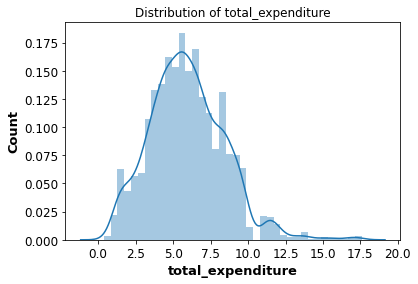

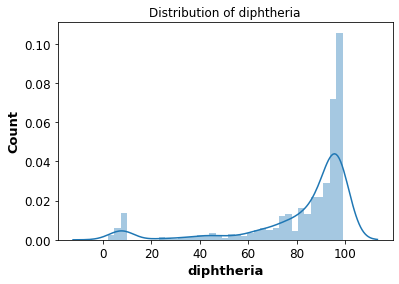

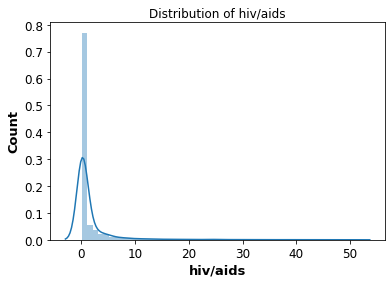

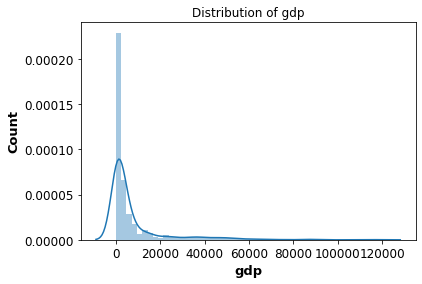

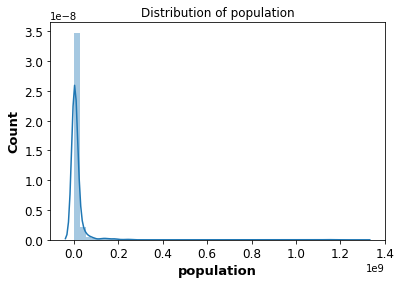

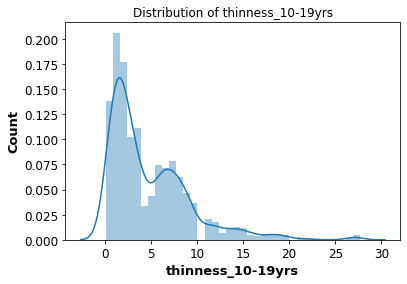

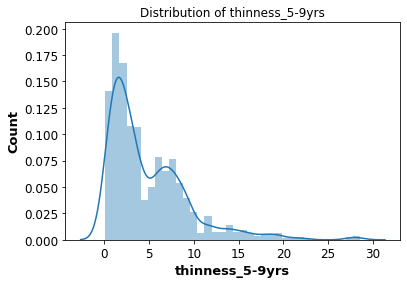

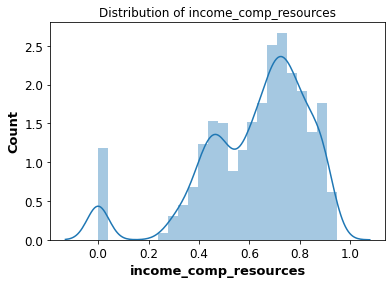

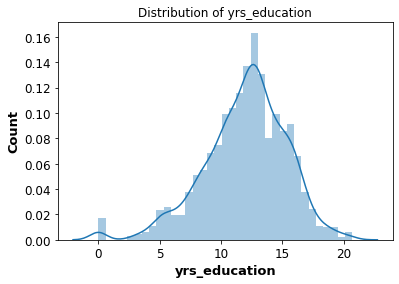

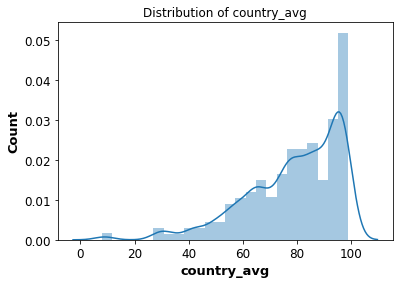

In [9]:
explore.distplot(df, df.columns)

In [15]:
df.sample(10).T

,167,1376,625,1474,20,1878,1550,1803,2439,2424
country,Bahamas,Kenya,Costa Rica,Lesotho,Albania,Niger,Luxembourg,Namibia,Spain,South Sudan
year,2008,2001,2015,2015,2011,2014,2003,2008,2001,2000
developed_country,0,0,0,0,0,0,1,0,1,0
life_expectancy,74.5,51.9,79.6,53.7,76.6,61.4,78.6,61.7,79.4,48.9
adult_mortality,167,434,95,484,88,223,92,317,84,38
infant_deaths,0,77,1,4,0,49,0,3,2,31
alcohol,10.15,1.63,NaN,NaN,5.37,0.01,12.61,6.28,9.86,NaN
pct_expenditure,0,3.8476,0,0,437.062,3.30404,10111.4,59.5503,2044.17,0
hep_b,9,74.5714,92,93,99,68,95,86.3333,83,31
measles,0,11304,0,0,28,1142,1,0,0,0


In [21]:
# investigate the nulls
df.isnull().sum()

country                    0
year                       0
developed_country          0
life_expectancy           10
adult_mortality           10
infant_deaths              0
alcohol                  194
pct_expenditure            0
hep_b                    144
measles                    0
bmi                       34
under_five_deaths          0
polio                     19
total_expenditure        226
diphtheria                19
hiv/aids                   0
gdp                      448
population               652
thinness_10-19yrs         34
thinness_5-9yrs           34
income_comp_resources    167
yrs_education            163
country_avg              144
dtype: int64

In [26]:
# investigate the nulls
df[df.country=='Germany'].gdp

994     41176.88158
995      4792.65288
996      4653.91143
997      4465.24891
998      4681.32796
999     41785.55691
1000    41732.77250
1001    45699.19832
1002    41814.81910
1003    36447.87232
1004    34696.62920
1005    34165.93430
1006     3359.95215
1007     2525.16445
1008    23687.31689
1009    23718.74670
Name: gdp, dtype: float64

In [18]:
df[df.country=='Saint Lucia'].population

2168   NaN
2169   NaN
2170   NaN
2171   NaN
2172   NaN
2173   NaN
2174   NaN
2175   NaN
2176   NaN
2177   NaN
2178   NaN
2179   NaN
2180   NaN
2181   NaN
2182   NaN
2183   NaN
Name: population, dtype: float64

In [27]:
# handle the nulls
df['country_avg'] = df.groupby('country').hep_b.transform('mean')
df.hep_b = df.hep_b.fillna(df.country_avg)

# population column has too many to impute and the data is wrong, distribution is all over the place
# df.drop(columns=['population','gdp'], inplace=True)

In [ ]:
.transform()

### Prepare Takeaways:
 - T

## Explore